In [1]:
import torch
import librosa as li 
import soundfile as sf
from typing import Any, Callable, Optional, Union
import torch.nn.functional as F
from einops import repeat
from torch import nn
import time
import pyaudio
import wave
import numpy as np
import soundfile as sf
import torch
from pythonosc import dispatcher, osc_server
from collections import deque
import pyaudio
import numpy as np
from threading import Thread

wav_path = "/Users/nikny/musing_instruments/data/stravinski_wav/01 Petroushka (Original 1911 Version), First Scene_ I. The Shrove-tide Fair.wav"
model_path1 = "/Users/nikny/Downloads/percussion.ts"
model_path2 = "/Users/nikny/Downloads/nasa.ts"
model_path3 = "/Users/nikny/Downloads/vintage.ts" #too heavy
perturbation_tensors = {0: torch.ones(47)}


def osc_callback0(addr, *args):

    perturbation_tensors[0][0] *= args[0]#tensor
    print('updated 0')

def osc_callback1(addr, *args):

    perturbation_tensors[0][1] *= args[0]#tensor
    print('updated 1')

def osc_callback2(addr, *args):

    perturbation_tensors[0][2] *= args[0]#tensor
    print('updated 2')

def osc_callback3(addr, *args):

    perturbation_tensors[0][3] *= args[0]#tensor
    print('updated 3')

# Setting up the OSC server
def start_osc_server(ip, port):
    disp = dispatcher.Dispatcher()
    disp.map("/latent_perturbations0", osc_callback0)
    disp.map("/latent_perturbations1", osc_callback1)
    disp.map("/latent_perturbations2", osc_callback2)
    disp.map("/latent_perturbations3", osc_callback3)
    server = osc_server.ThreadingOSCUDPServer((ip, port), disp)
    print(f"Serving on {server.server_address}")
    server.serve_forever()


def convert_wav_to_float32(input_path, output_path):
    # Open the wav file
    with wave.open(input_path, 'rb') as wav_file:
        # Extract audio data and parameters
        n_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        framerate = wav_file.getframerate()
        n_frames = wav_file.getnframes()
        audio_data = wav_file.readframes(n_frames)

        # Convert audio data to numpy array depending on the sample width
        if sample_width == 1:  # 8-bit WAV files are unsigned
            data = np.frombuffer(audio_data, dtype=np.uint8) - 128
        elif sample_width == 2:  # 16-bit WAV files are signed
            data = np.frombuffer(audio_data, dtype=np.int16)
        else:
            raise ValueError("Only supports 8 or 16 bit audio formats.")

        # Normalize the data to the range between -1.0 and 1.0
        max_int_value = float(2 ** (8 * sample_width - 1))
        data = data / max_int_value

        # Write the data to a new file
        sf.write(output_path, data, framerate, 'FLOAT')

# Replace 'input_path.wav' and 'output_path.wav' with the actual paths
convert_wav_to_float32(wav_path, 'output_path_float32.wav')

convert_wav_to_float32(wav_path, 'output_path_float32.wav')
torch.set_grad_enabled(False)
model = torch.jit.load(model_path1).eval()
x = li.load("output_path_float32.wav")[0]
x = torch.from_numpy(x).reshape(1, 1, -1)

p = pyaudio.PyAudio()
osc_thread = Thread(target=start_osc_server, args=('127.0.0.1', 4548))
osc_thread.start()
# Assuming the audio is mono (1 channel) and float32 format, adjust as needed
stream = p.open(format=pyaudio.paFloat32,  # float32 format
                channels=1,                # Mono audio
                rate=44100,                # Sample rate
                output=True,               # Output stream
                output_device_index=2) 

buffer_length = 8192
model_lookback = 96000
output_buffer = []
for i in range((x.shape[2] // buffer_length) - 13):
    #t = time.time()
    z = model.encode(x[:, :, (model_lookback + i*buffer_length):(2*model_lookback + i*buffer_length)])
    z[:, 2] += perturbation_tensors[0]# torch.linspace(-2, 2, z.shape[-1])
    y = model.decode(z).numpy().reshape(-1)
    last_samples = y[-buffer_length:].astype('float32').tobytes()
    # Write to PyAudio stream
    stream.write(last_samples)
    #print(y.shape)
    #print(time.time() - t)

stream.stop_stream()
stream.close()

# Terminate PyAudio
p.terminate()

Serving on ('127.0.0.1', 4548)


KeyboardInterrupt: 

In [7]:
y.shape

(192512,)

In [9]:
y.shape

(192512,)

In [81]:
import torch
import torch.nn as nn
import cached_conv as cc

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = cc.CachedSequential(
            cc.Conv1d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            cc.Conv1d(16, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            cc.Conv1d(16, 16, 3, stride=2, padding=1),
        )

        self.decoder = cc.CachedSequential(
            cc.ConvTranspose1d(16, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            cc.ConvTranspose1d(16, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            cc.ConvTranspose1d(16, 1, 4, stride=2, padding=1),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [89]:
from torch.optim import Adam, AdamW
cc.use_cached_conv(True)
model = AutoEncoder()
optimizer = AdamW(model.parameters(), lr = 0.01)



In [101]:
model_path1 = "/Users/nikny/Downloads/percussion.ts"
torch.set_grad_enabled(True)
model = torch.jit.load(model_path1)

In [102]:
model.train()
DataX, DataY = torch.randn(S, 1, 1, 4096), torch.randn(S, 1, 1, 4096)
optimizer.zero_grad()
o = model(DataX[3])
loss = torch.norm(o - DataY[3])
loss.backward()
optimizer.step()

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__.py", line 23, in forward
  def forward(self: __torch__.TraceModel,
    x: Tensor) -> Tensor:
    return (self).decode((self).encode(x, ), )
                          ~~~~~~~~~~~~ <--- HERE
  def decode(self: __torch__.TraceModel,
    z: Tensor) -> Tensor:
  File "code/__torch__.py", line 92, in encode
    x4 = (pqmf).forward(x3, )
    encoder = self.encoder
    mean, scale, = (encoder).forward(x4, )
                    ~~~~~~~~~~~~~~~~ <--- HERE
    _10 = (self).post_process_distribution(mean, scale, )
    mean0, std, = _10
  File "code/__torch__/rave/model.py", line 11, in forward
    x: Tensor) -> List[Tensor]:
    net = self.net
    z = (net).forward(x, )
         ~~~~~~~~~~~~ <--- HERE
    _0 = torch.floordiv((torch.size(z))[1], 2)
    return torch.split(z, _0, 1)
  File "code/__torch__/cached_conv/convs.py", line 106, in forward
    _13 = getattr(self, "13")
    _14 = getattr(self, "14")
    input0 = (_0).forward(input, )
              ~~~~~~~~~~~ <--- HERE
    input1 = (_1).forward(input0, )
    input2 = (_2).forward(input1, )
  File "code/__torch__/cached_conv/convs/___torch_mangle_1.py", line 27, in forward
    x0 = (downsampling_delay).forward(x, )
    cache = self.cache
    x1 = (cache).forward(x0, )
          ~~~~~~~~~~~~~~ <--- HERE
    weight = self.weight
    bias = self.bias
  File "code/__torch__/cached_conv/convs.py", line 56, in forward
      padding0 = self.padding
      _2 = torch.slice(x3, -1, torch.neg(padding0))
      _3 = torch.copy_(pad0, _2)
           ~~~~~~~~~~~ <--- HERE
      crop = self.crop
      if crop:

Traceback of TorchScript, original code (most recent call last):
  File "/slow-2/antoine/projects/instances/release/export_rave.py", line 197, in forward
    def forward(self, x):
        return self.decode(self.encode(x))
                           ~~~~~~~~~~~ <--- HERE
  File "/slow-2/antoine/projects/instances/release/export_rave.py", line 116, in encode
            x = self.pqmf(x)
    
        mean, scale = self.encoder(x)
                      ~~~~~~~~~~~~ <--- HERE
        mean, std = self.post_process_distribution(mean, scale)
    
  File "/slow-2/antoine/projects/instances/release/rave/model.py", line 344, in forward
    def forward(self, x):
        z = self.net(x)
            ~~~~~~~~ <--- HERE
        return torch.split(z, z.shape[1] // 2, 1)
  File "/slow-2/antoine/miniconda3/envs/RAVE/lib/python3.9/site-packages/torch/nn/modules/container.py", line 141, in forward
    def forward(self, input):
        for module in self:
            input = module(input)
                    ~~~~~~ <--- HERE
        return input
  File "/slow-2/antoine/miniconda3/envs/RAVE/lib/python3.9/site-packages/cached_conv/convs.py", line 120, in forward
    def forward(self, x):
        x = self.downsampling_delay(x)
        x = self.cache(x)
            ~~~~~~~~~~ <--- HERE
        return nn.functional.conv1d(
            x,
  File "/slow-2/antoine/miniconda3/envs/RAVE/lib/python3.9/site-packages/cached_conv/convs.py", line 78, in forward
        if self.padding:
            x = torch.cat([self.pad, x], -1)
            self.pad.copy_(x[..., -self.padding:])
            ~~~~~~~~~~~~~~ <--- HERE
    
            if self.crop:
RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.


In [16]:
len(optimizer.param_groups[0]['params'])

12

In [42]:
optimizer.param_groups[0]['params'][6].shape

torch.Size([16, 16, 4])

In [43]:
optimizer.state_dict

<bound method Optimizer.state_dict of AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)>

In [80]:
# Assume model is your neural network model and optimizer is initialized
#optimizer = Adam(model.parameters(), lr=0.01)

# After performing some training steps
for param in model.parameters():
    state = optimizer.state[param]
    exp_avg = state.get('exp_avg')
    exp_avg_sq = state.get('exp_avg_sq')
    print("exp_avg:", exp_avg)
    print("exp_avg_sq:", exp_avg_sq)


# during training store: for each paremeter in model.parameters(), store a neural summation of the 
# optimizer.state[parameter], in a graph-structure with encoded connectivity of the model architecture by a GNN, 
# during training also store (input_feature, input_data, criterion/task, MI(model_optimizer_graph, reward)), 
# save this summary as the model's fingerprint. Use the fingerprint summary downstream to optimize finetuning 
# of model and reward function. Also as a way to explicitly correlate and control the latent dimensions of the encoding 
# to different learnt features, which are themselves biased by the style characteristics inherited from the dataset/feature-mappings 
# and reward function evolution learnt through the training and finetuning process.


exp_avg: tensor([[ 1.2733e-03,  2.4114e-06, -8.1230e-03,  ...,  6.3951e-03,
          3.2222e-03,  4.4032e-03],
        [ 7.4183e-04,  3.8198e-03,  1.7003e-03,  ...,  1.2080e-03,
         -1.1888e-03, -3.4950e-03],
        [-5.0784e-04,  4.1229e-04, -3.6956e-03,  ...,  7.6238e-03,
         -5.1172e-04, -1.0482e-03],
        ...,
        [-1.2483e-03, -3.5841e-04,  2.8999e-03,  ..., -9.5514e-03,
          9.2199e-04, -4.0033e-03],
        [-1.7406e-04,  2.9575e-03, -3.7766e-03,  ...,  6.9287e-03,
         -3.8486e-03,  2.3028e-03],
        [ 1.0000e-03, -2.0914e-03,  5.0888e-04,  ..., -1.3420e-03,
          1.1733e-03, -2.2819e-03]])
exp_avg_sq: tensor([[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        ...,
        [0.0002, 0.0002, 0.0003,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0003,  ..., 0.0002, 0.0002, 0.0002],
        [0.000

In [76]:
q = optimizer.state

In [91]:
model = nn.Sequential(nn.Linear(100, 100), nn.Linear(100, 100), nn.Linear(100, 100), nn.Linear(100, 100))
optimizer = AdamW(model.parameters(), lr = 0.001)
S = 1000
DataX, DataY = torch.randn(S, 100), torch.randn(S, 100)

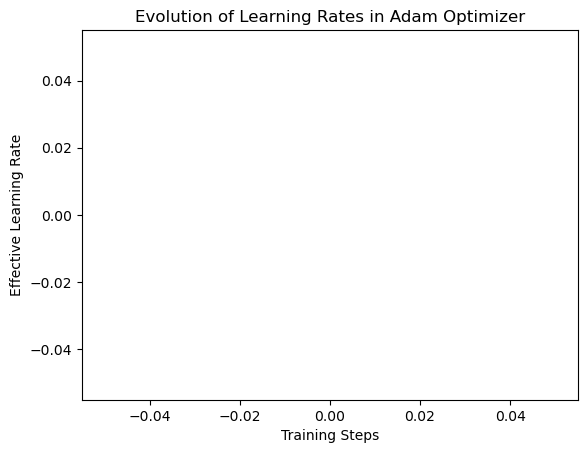

In [92]:
import matplotlib.pyplot as plt
S = 1000

lr_evolution = []
for i in range(S):
    optimizer.zero_grad()
    o = model(DataX[i])
    loss = torch.norm(o - DataY[i])
    loss.backward()
    optimizer.step()
    #for group in optimizer.param_groups:
    #    for p in group['params']:
            #if p.grad is not None:
    #                state = optimizer.state[p]
                    # Compute effective learning rate for this parameter
                    # This is a simplified version, actual computation may vary
                    # depending on the exact version of Adam you're using
    #                lr = group['lr'] * (state.get('exp_avg_sq').sqrt() + 1e-8)
    #                lr_evolution.append(lr.item())

# Plotting
plt.plot(lr_evolution)
plt.xlabel('Training Steps')
plt.ylabel('Effective Learning Rate')
plt.title('Evolution of Learning Rates in Adam Optimizer')
plt.show()

In [31]:
optimizer.state_dict()

{'state': {0: {}},
 'param_groups': [{'lr': 0.01,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}]}

In [59]:
t = torch.rand(1, 1, 1024)
model(t)
model.register_buffer("forward_params", torch.tensor([1, 1, 1, 1]))

In [50]:
scripted_model = torch.jit.script(model)

In [51]:
torch.jit.save(scripted_model, "exported_model.ts")

In [60]:
model.register_buffer("forward_params", torch.tensor([1, 1, 1, 1]))
scripted_model = torch.jit.script(model)
torch.jit.save(scripted_model, "exported_model.ts")

In [5]:
p = torch.ones_like(z)
z += p

In [46]:
torch.linspace(-2, 2, z.shape[-1]).shape

torch.Size([47])

In [45]:
torch.zeros(47).shape

torch.Size([47])

In [ ]:
import torch
from pythonosc import dispatcher, osc_server
from collections import deque
import pyaudio
import numpy as np
from threading import Thread

# Define the CircularBuffer class as per the user's description
class CircularBuffer:
    def __init__(self, size, tensor_shape):
        self.size = size
        self.buffer = deque(maxlen=size)
        self.tensor_shape = tensor_shape

    def add(self, tensor):
        if tensor.shape == self.tensor_shape:
            self.buffer.append(tensor)
        else:
            raise ValueError("Tensor shape does not match the buffer's tensor shape")

    def get(self, index):
        if index < 0 or index >= len(self.buffer):
            raise IndexError("Index out of range")
        return self.buffer[index]

# Define constants for the audio stream
SAMPLE_RATE = 44100
BUFFER_SIZE = 2048

# Initialize the circular buffer for input tensors
input_tensors = CircularBuffer(size=2, tensor_shape=(1, 4, 1))

# Load the model
model = torch.jit.load("/Users/nikny/Downloads/percussion.ts").eval()

# Audio callback function
def audio_callback(in_data, frame_count, time_info, status):
    x = torch.tensor(np.frombuffer(in_data, dtype=np.float32), dtype=torch.float32)
    x = x.reshape(1, 1, -1)  # Reshape to (1, 1, 2048)
    
    z = model.encode(x)
    z += input_tensors.get(0)
    y = model.decode(z)
    
    # Convert y to stereo and float32 for PyAudio output
    y_np = y.detach().numpy().astype(np.float32).reshape(-1)
    out_data = y_np.tobytes()
    
    return (out_data, pyaudio.paContinue)

# OSC callback function
def osc_callback(addr, *args):
    # Convert the incoming float values to a torch tensor with the shape (1, 4, 1)
    tensor = torch.tensor([[args]], dtype=torch.float32)
    # Add the tensor to the circular buffer
    input_tensors.add(tensor)

# Setting up the OSC server
def start_osc_server(ip, port):
    disp = dispatcher.Dispatcher()
    disp.map("/latent_perturbations", osc_callback)
    server = osc_server.ThreadingOSCUDPServer((ip, port), disp)
    print(f"Serving on {server.server_address}")
    server.serve_forever()

# Initialize PyAudio
p = pyaudio.PyAudio()

# Open the audio stream
stream = p.open(format=pyaudio.paFloat32,
                channels=2,
                rate=SAMPLE_RATE,
                input=True,
                output=True,
                frames_per_buffer=BUFFER_SIZE,
                stream_callback=audio_callback)

# Start the OSC server in a new thread
osc_thread = Thread(target=start_osc_server, args=('127.0.0.1', 12345))
osc_thread.start()

# Start the audio stream
stream.start_stream()

# Keep the main thread alive
try:
    while stream.is_active():
        # You could do some processing here, or just keep the thread alive
        time.sleep(0.1)
except KeyboardInterrupt:
    # Stop and close the stream and server
    stream.stop_stream()
    stream.close()
    p.terminate()
    osc_thread.join()

print("Shutting down")

In [42]:
torch.linspace(-2, 2, z.shape[-1])

tensor([-2.0000, -1.9130, -1.8261, -1.7391, -1.6522, -1.5652, -1.4783, -1.3913,
        -1.3043, -1.2174, -1.1304, -1.0435, -0.9565, -0.8696, -0.7826, -0.6957,
        -0.6087, -0.5217, -0.4348, -0.3478, -0.2609, -0.1739, -0.0870,  0.0000,
         0.0870,  0.1739,  0.2609,  0.3478,  0.4348,  0.5217,  0.6087,  0.6957,
         0.7826,  0.8696,  0.9565,  1.0435,  1.1304,  1.2174,  1.3043,  1.3913,
         1.4783,  1.5652,  1.6522,  1.7391,  1.8261,  1.9130,  2.0000])

In [54]:
torch.linspace(-2, 2, z.shape[-1]).shape

torch.Size([541])

In [2]:
wav_path = "/Users/nikny/musing_instruments/data/stravinski_wav/01 Petroushka (Original 1911 Version), First Scene_ I. The Shrove-tide Fair.wav"
model_path = "/Users/nikny/Downloads/percussion.ts"

In [3]:
torch.set_grad_enabled(False)
model = torch.jit.load("/Users/nikny/Downloads/percussion.ts").eval()
x = li.load("/Users/nikny/musing_instruments/data/stravinski_wav/01 Petroushka (Original 1911 Version), First Scene_ I. The Shrove-tide Fair.wav")[0]
x = torch.from_numpy(x).reshape(1, 1, -1)
t = time.time()
z = model.encode(x)
#z[:, 3] += torch.linspace(-2, 2, z.shape[-1])
y = model.decode(z).numpy().reshape(-1)
print(time.time()-t)
sf.write("out.wav", y, 44100)

0.678006649017334


In [6]:
wav_path = "/Users/nikny/musing_instruments/data/stravinski_wav/01 Petroushka (Original 1911 Version), First Scene_ I. The Shrove-tide Fair.wav"
model_path = "/Users/nikny/Downloads/percussion.ts"
convert_wav_to_float32(wav_path, 'output_path_float32.wav')
torch.set_grad_enabled(False)
model = torch.jit.load(model_path).eval()
x = li.load("output_path_float32.wav")[0]
x = torch.from_numpy(x).reshape(1, 1, -1)
t = time.time()
z = model.encode(x)
#z[:, 3] += torch.linspace(-2, 2, z.shape[-1])
y = model.decode(z).numpy().reshape(-1)
print(time.time()-t)
sf.write("out.wav", y, 44100)

1.1364128589630127


In [250]:
x.shape[2] // buffer_length 

270

In [10]:
(x.shape[2] // buffer_length) - 12

258

In [19]:
i = 258
z = model.encode(x[:, :, (96000 + i*buffer_length):(96000 + 2*i*buffer_length)])
y = model.decode(z).numpy().reshape(-1)
print('code works')

code works


In [31]:
y.shape

(49152,)

In [34]:
192512/2

96256.0

In [35]:
import torch
import librosa as li 
import soundfile as sf
from typing import Any, Callable, Optional, Union
import torch.nn.functional as F
from einops import repeat
from torch import nn
import time
import pyaudio

KeyboardInterrupt: 

In [5]:
import wave
import numpy as np
import soundfile as sf

def convert_wav_to_float32(input_path, output_path):
    # Open the wav file
    with wave.open(input_path, 'rb') as wav_file:
        # Extract audio data and parameters
        n_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        framerate = wav_file.getframerate()
        n_frames = wav_file.getnframes()
        audio_data = wav_file.readframes(n_frames)

        # Convert audio data to numpy array depending on the sample width
        if sample_width == 1:  # 8-bit WAV files are unsigned
            data = np.frombuffer(audio_data, dtype=np.uint8) - 128
        elif sample_width == 2:  # 16-bit WAV files are signed
            data = np.frombuffer(audio_data, dtype=np.int16)
        else:
            raise ValueError("Only supports 8 or 16 bit audio formats.")

        # Normalize the data to the range between -1.0 and 1.0
        max_int_value = float(2 ** (8 * sample_width - 1))
        data = data / max_int_value

        # Write the data to a new file
        sf.write(output_path, data, framerate, 'FLOAT')

# Replace 'input_path.wav' and 'output_path.wav' with the actual paths
convert_wav_to_float32(wav_path, 'output_path_float32.wav')

In [111]:
y.shape, x.shape

((2215936,), torch.Size([1, 1, 1107936]))

In [107]:
1107936*2

2215872

In [102]:
model.encode(x).shape

torch.Size([1, 4, 541])

In [56]:
z.shape

torch.Size([1, 4, 541])

In [51]:
x.shape

torch.Size([1, 1, 1107936])

In [742]:
x.shape

torch.Size([1, 1, 1107936])

In [740]:
z[:, 2].shape

torch.Size([1, 541])

In [739]:
z[:, 2] += torch.linspace(-2, 2, z.shape[-1])
y = model.decode(z).numpy().reshape(-1)
sf.write("out.wav", y, 44100)

In [780]:
1538/44100

0.03487528344671202

In [971]:
torch.linspace(-2, 2, z.shape[-1]).shape

torch.Size([1])

In [204]:
4096*2

8192

In [ ]:
# app workflow:
# input 2 sec of audio to the model streamed from a .wav file
# select last buffer of 8192 samples from the model output and put to audio output stream buffer, then move timewindow of audiofile forward one 8192 s buffer
# 

In [203]:
x = torch.rand(1, 1, 1*96000)
t = time.time()
z = model.encode(x)
print('encoding time = ' ,time.time()-t)
z[:, 2] += torch.linspace(-2, 2, z.shape[-1])
t = time.time()
y = model.decode(z)
print('model processing time = ', time.time()-t)
z.shape


encoding time =  0.0077631473541259766
model processing time =  0.05507612228393555


torch.Size([1, 4, 47])

In [20]:

p = pyaudio.PyAudio()
def list_audio_devices():
    num_devices = p.get_device_count()
    for i in range(num_devices):
        info = p.get_device_info_by_index(i)
        print(f"Device {i}: {info['name']} (Input channels: {info['maxInputChannels']})")

# List all audio devices
list_audio_devices()

Device 0: BlackHole 64ch (Input channels: 64)
Device 1: MacBook Pro Microphone (Input channels: 1)
Device 2: MacBook Pro Speakers (Input channels: 0)
Device 3: Serato Virtual Audio (Input channels: 2)
Device 4: Multi-Output Device (Input channels: 0)


In [12]:
import wave
import numpy as np
import soundfile as sf

def convert_wav_to_float32(input_path, output_path):
    # Open the wav file
    with wave.open(input_path, 'rb') as wav_file:
        # Extract audio data and parameters
        n_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        framerate = wav_file.getframerate()
        n_frames = wav_file.getnframes()
        audio_data = wav_file.readframes(n_frames)

        # Convert audio data to numpy array depending on the sample width
        if sample_width == 1:  # 8-bit WAV files are unsigned
            data = np.frombuffer(audio_data, dtype=np.uint8) - 128
        elif sample_width == 2:  # 16-bit WAV files are signed
            data = np.frombuffer(audio_data, dtype=np.int16)
        else:
            raise ValueError("Only supports 8 or 16 bit audio formats.")

        # Normalize the data to the range between -1.0 and 1.0
        max_int_value = float(2 ** (8 * sample_width - 1))
        data = data / max_int_value

        # Write the data to a new file
        sf.write(output_path, data, framerate, 'FLOAT')

# Replace 'input_path.wav' and 'output_path.wav' with the actual paths
convert_wav_to_float32(wav_path, 'output_path_float32.wav')


In [18]:
def convert_wav_to_float32(input_path, output_path):
    # Open the wav file
    with wave.open(input_path, 'rb') as wav_file:
        # Extract audio data and parameters
        n_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        framerate = wav_file.getframerate()
        n_frames = wav_file.getnframes()
        audio_data = wav_file.readframes(n_frames)

        # Check the format of the file and convert accordingly
        if sample_width == 1:  # 8-bit WAV files are unsigned
            data = np.frombuffer(audio_data, dtype=np.uint8) - 128
        elif sample_width == 2:  # 16-bit WAV files are signed
            data = np.frombuffer(audio_data, dtype=np.int16)
        else:
            raise ValueError("Unsupported audio format.")

        # Normalize the data to the range between -1.0 and 1.0
        data = data.astype(np.float32)  # First convert to float32
        max_int_value = float(2 ** (8 * sample_width - 1))
        data = data / max_int_value

        # Reshape the data if it's stereo to 2 columns
        if n_channels == 2:
            data = np.reshape(data, (-1, n_channels))

        # Write the data to a new file with the same sample rate as the original
        sf.write(output_path, data, framerate, 'FLOAT')

convert_wav_to_float32(wav_path, 'output_path_float32.wav')

In [19]:
import pyaudio
import soundfile as sf
import torch
from pythonosc import dispatcher, osc_server
from collections import deque
import pyaudio
import numpy as np
from threading import Thread
import time
import wave

wav_path = "/Users/nikny/musing_instruments/data/stravinski_wav/01 Petroushka (Original 1911 Version), First Scene_ I. The Shrove-tide Fair.wav"

vae = torch.jit.load("/Users/nikny/Downloads/percussion.ts").eval()

# Constants for the audio properties
FORMAT = pyaudio.paFloat32#paInt16
CHANNELS = 2
RATE = 44100
CHUNK = 2048


def convert_wav_to_float32(input_path, output_path):
    # Open the wav file
    with wave.open(input_path, 'rb') as wav_file:
        # Extract audio data and parameters
        n_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        framerate = wav_file.getframerate()
        n_frames = wav_file.getnframes()
        audio_data = wav_file.readframes(n_frames)

        # Check the format of the file and convert accordingly
        if sample_width == 1:  # 8-bit WAV files are unsigned
            data = np.frombuffer(audio_data, dtype=np.uint8) - 128
        elif sample_width == 2:  # 16-bit WAV files are signed
            data = np.frombuffer(audio_data, dtype=np.int16)
        else:
            raise ValueError("Unsupported audio format.")

        # Normalize the data to the range between -1.0 and 1.0
        data = data.astype(np.float32)  # First convert to float32
        max_int_value = float(2 ** (8 * sample_width - 1))
        data = data / max_int_value

        # Reshape the data if it's stereo to 2 columns
        if n_channels == 2:
            data = np.reshape(data, (-1, n_channels))

        # Write the data to a new file with the same sample rate as the original
        sf.write(output_path, data, framerate, 'FLOAT')

convert_wav_to_float32(wav_path, 'output_path_float32.wav')


def audio_callback_(in_data, frame_count, time_info, flag):
    with torch.no_grad():
        audio_data = np.frombuffer(in_data, dtype=np.float32)
        x = torch.tensor(audio_data).view(1, 1, -1)

        # Forward pass through the model
        z = vae.encode(x)
        y = vae.decode(z)

        out_data = y.numpy().astype(np.float32).tobytes()


# Constants for the audio properties
FORMAT = pyaudio.paFloat32#paInt16
CHANNELS = 2
RATE = 44100
CHUNK = 2048


def play_wav(path):
    with sf.SoundFile(path) as sf_data:
        # Initialize the PyAudio interface
        p = pyaudio.PyAudio()

        # Open a stream
        stream = p.open(format=FORMAT,
                        channels=sf_data.channels,
                        rate=sf_data.samplerate,
                        output=True,
                        stream_callback=audio_callback_)

        # Start the stream
        stream.start_stream()

        # Wait for the stream to finish
        while stream.is_active():
            time.sleep(0.1)

        # Stop and close the stream
        stream.stop_stream()
        stream.close()

        # Terminate the PyAudio object
        p.terminate()

# Replace 'path_to_your_file.wav' with the path to the .wav file you want to play



play_wav('output_path_float32.wav')


TypeError: a bytes-like object is required, not 'NoneType'

TypeError: 

In [ ]:
import torch
from pythonosc import dispatcher, osc_server
from collections import deque
import pyaudio
import numpy as np
from threading import Thread
import time
import wave

vae = torch.jit.load("/Users/nikny/Downloads/percussion.ts").eval()
pert = torch.linspace(-2, 2, 1)
output = []
SAMPLE_RATE = 44100
BUFFER_SIZE = 2048
p = pyaudio.PyAudio()
# Audio callback function
def audio_callback(in_data, frame_count, time_info, flag):
    # No gradients required for inference
    with torch.no_grad():
        # Convert the input buffer to a torch tensor
        audio_data = np.frombuffer(in_data, dtype=np.float32)
        x = torch.tensor(audio_data).view(1, 1, -1)

        # Forward pass through the model
        z = vae.encode(x)
        #z += pert# input_tensors.get(0)
        y = vae.decode(z)
        print(y)
        # Convert the output to bytes and return it
        out_data = y.numpy().astype(np.float32).tobytes()
        output.append(out_data)
        return (out_data, pyaudio.paContinue)
    
def audio_callback_(in_data, frame_count, time_info, flag):
    with torch.no_grad():
        #out.append(0)
        audio_data = np.frombuffer(in_data, dtype=np.float32)
        x = torch.tensor(audio_data).view(1, 1, -1)

        # Forward pass through the model
        z = vae.encode(x)
        z += pert  # Assuming 'pert' is a tensor with the right shape to be added to 'z'
        y = vae.decode(z)
        output.append(y.numpy().astype(np.float32))
        #print(y.shape)

        # Check if y contains valid audio data

        # Convert the tensor to stereo if needed
        #y_stereo = y.repeat(1, 2, 1)  # Repeat the mono signal across two channels for stereo

        # Make sure the audio data is in the right range and type
        out_data = y.numpy().astype(np.float32).tobytes()
        

        return (out_data, pyaudio.paContinue)



stream = p.open(format=pyaudio.paFloat32,
                    channels=1,  # Use 1 channel for input
                    #output_channels=2,  # Use 2 channels for output if your device supports it
                    rate=SAMPLE_RATE,
                    output=True,
                    output_device_index=2,
                    frames_per_buffer=BUFFER_SIZE,
                    stream_callback=audio_callback_)


# Start the audio stream
stream.start_stream()

# Keep the main thread alive
try:
    while stream.is_active():
        # You could do some processing here, or just keep the thread alive
        time.sleep(0.1)
except KeyboardInterrupt:
    # Stop and close the stream and server
    stream.stop_stream()
    stream.close()
    p.terminate()

In [27]:
import torch
from pythonosc import dispatcher, osc_server
from collections import deque
import pyaudio
import numpy as np
from threading import Thread
import time
import wave

vae = torch.jit.load("/Users/nikny/Downloads/percussion.ts").eval()
pert = torch.linspace(-2, 2, 1)
output = []
SAMPLE_RATE = 44100
BUFFER_SIZE = 2048
p = pyaudio.PyAudio()
# Audio callback function
def audio_callback(in_data, frame_count, time_info, flag):
    # No gradients required for inference
    with torch.no_grad():
        # Convert the input buffer to a torch tensor
        audio_data = np.frombuffer(in_data, dtype=np.float32)
        x = torch.tensor(audio_data).view(1, 1, -1)

        # Forward pass through the model
        z = vae.encode(x)
        #z += pert# input_tensors.get(0)
        y = vae.decode(z)
        print(y)
        # Convert the output to bytes and return it
        out_data = y.numpy().astype(np.float32).tobytes()
        output.append(out_data)
        return (out_data, pyaudio.paContinue)
    
def audio_callback_(in_data, frame_count, time_info, flag):
    with torch.no_grad():
        #out.append(0)
        audio_data = np.frombuffer(in_data, dtype=np.float32)
        x = torch.tensor(audio_data).view(1, 1, -1)

        # Forward pass through the model
        z = vae.encode(x)
        z += pert  # Assuming 'pert' is a tensor with the right shape to be added to 'z'
        y = vae.decode(z)
        output.append(y.numpy().astype(np.float32))
        #print(y.shape)

        # Check if y contains valid audio data

        # Convert the tensor to stereo if needed
        #y_stereo = y.repeat(1, 2, 1)  # Repeat the mono signal across two channels for stereo

        # Make sure the audio data is in the right range and type
        out_data = y.numpy().astype(np.float32).tobytes()
        

        return (out_data, pyaudio.paContinue)



stream = p.open(format=pyaudio.paFloat32,
                    channels=1,  # Use 1 channel for input
                    #output_channels=2,  # Use 2 channels for output if your device supports it
                    rate=SAMPLE_RATE,
                    input=True,
                    output=True,
                    input_device_index=1,
                    output_device_index=2,
                    frames_per_buffer=BUFFER_SIZE,
                    stream_callback=audio_callback_)


# Start the audio stream
stream.start_stream()

# Keep the main thread alive
try:
    while stream.is_active():
        # You could do some processing here, or just keep the thread alive
        time.sleep(0.1)
except KeyboardInterrupt:
    # Stop and close the stream and server
    stream.stop_stream()
    stream.close()
    p.terminate()
    # Convert the list of byte strings to a single bytes object
    audio_bytes = b''.join(output)

    # Define the output WAV file
    output_filename = 'output.wav'

    # Open the output file
    wf = wave.open(output_filename, 'wb')

    # Set the number of channels
    wf.setnchannels(1)

    # Set the sample width to 4 bytes (32 bits)
    wf.setsampwidth(p.get_sample_size(pyaudio.paFloat32))

    # Set the frame rate
    wf.setframerate(SAMPLE_RATE)

    # Write the frames to the file
    wf.writeframes(audio_bytes)

    # Close the file
    wf.close()

    print(f"Shutting down and saving the recording to {output_filename}")
    

print("Shutting down")

Shutting down and saving the recording to output.wav
Shutting down


In [47]:
output[0][0][0].shape

(2048,)

In [37]:
for i in range(len(output)):
    if np.abs(output[0][0][i]) > 1:
        print(i, ' ',output[i])

for i in range(len(output)):
    if np.abs(output[1][0][i]) > 1:
        print(i, ' ',output[i])



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [22]:
out

[]

In [976]:
import torch
from pythonosc import dispatcher, osc_server
from collections import deque
import pyaudio
import numpy as np
from threading import Thread

# Define the CircularBuffer class as per the user's description
class CircularBuffer:
    def __init__(self, size, tensor_shape):
        self.size = size
        self.buffer = deque(maxlen=size)
        self.tensor_shape = tensor_shape

    def add(self, tensor):
        if tensor.shape == self.tensor_shape:
            self.buffer.append(tensor)
        else:
            raise ValueError("Tensor shape does not match the buffer's tensor shape")

    def get(self, index):
        if index < 0 or index >= len(self.buffer):
            raise IndexError("Index out of range")
        return self.buffer[index]

# Define constants for the audio stream
SAMPLE_RATE = 44100
BUFFER_SIZE = 2048

# Initialize the circular buffer for input tensors
input_tensors = CircularBuffer(size=2, tensor_shape=(1, 4, 1))

# Load the model
model = torch.jit.load("/Users/nikny/Downloads/percussion.ts").eval()

# Audio callback function
def audio_callback(in_data, frame_count, time_info, status):
    x = torch.tensor(np.frombuffer(in_data, dtype=np.float32), dtype=torch.float32)
    x = x.reshape(1, 1, -1)  # Reshape to (1, 1, 2048)
    
    z = model.encode(x)
    z += input_tensors.get(0)
    y = model.decode(z)
    
    # Convert y to stereo and float32 for PyAudio output
    y_np = y.detach().numpy().astype(np.float32).reshape(-1)
    out_data = y_np.tobytes()
    
    return (out_data, pyaudio.paContinue)

# OSC callback function
def osc_callback(addr, *args):
    # Convert the incoming float values to a torch tensor with the shape (1, 4, 1)
    tensor = torch.tensor([[args]], dtype=torch.float32)
    # Add the tensor to the circular buffer
    input_tensors.add(tensor)

# Setting up the OSC server
def start_osc_server(ip, port):
    disp = dispatcher.Dispatcher()
    disp.map("/latent_perturbations", osc_callback)
    server = osc_server.ThreadingOSCUDPServer((ip, port), disp)
    print(f"Serving on {server.server_address}")
    server.serve_forever()

# Initialize PyAudio
p = pyaudio.PyAudio()

# Open the audio stream
stream = p.open(format=pyaudio.paFloat32,
                channels=2,
                rate=SAMPLE_RATE,
                input=True,
                output=True,
                frames_per_buffer=BUFFER_SIZE,
                stream_callback=audio_callback)

# Start the OSC server in a new thread
osc_thread = Thread(target=start_osc_server, args=('127.0.0.1', 12345))
osc_thread.start()

# Start the audio stream
stream.start_stream()

# Keep the main thread alive
try:
    while stream.is_active():
        # You could do some processing here, or just keep the thread alive
        time.sleep(0.1)
except KeyboardInterrupt:
    # Stop and close the stream and server
    stream.stop_stream()
    stream.close()
    p.terminate()
    osc_thread.join()

print("Shutting down")


OSError: [Errno -9998] Invalid number of channels

In [975]:
y.shape

torch.Size([1, 2, 2048])

In [899]:
for i in range(100):
    print(i)
    d =  i*2048
    x = torch.rand(1, 1, d)
    z = model.encode(x)
    

0


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__.py", line 90, in encode
    x3 = (resample).from_target_sampling_rate(x, )
    pqmf = self.pqmf
    x4 = (pqmf).forward(x3, )
          ~~~~~~~~~~~~~ <--- HERE
    encoder = self.encoder
    mean, scale, = (encoder).forward(x4, )
  File "code/__torch__/rave/pqmf.py", line 15, in forward
    x: Tensor) -> Tensor:
    forward_conv = self.forward_conv
    x0 = (forward_conv).forward(x, )
          ~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    x1 = __torch__.rave.pqmf.reverse_half(x0, )
    return x1
  File "code/__torch__/cached_conv/convs.py", line 30, in forward
    weight = self.weight
    bias = self.bias
    _0 = torch.conv1d(x1, weight, bias, [16], [0], [1])
         ~~~~~~~~~~~~ <--- HERE
    return _0
class CachedPadding1d(Module):

Traceback of TorchScript, original code (most recent call last):
  File "/slow-2/antoine/projects/instances/release/export_rave.py", line 114, in encode
    
        if self.pqmf is not None:
            x = self.pqmf(x)
                ~~~~~~~~~ <--- HERE
    
        mean, scale = self.encoder(x)
  File "/slow-2/antoine/projects/instances/release/rave/pqmf.py", line 266, in forward
    def forward(self, x):
        x = self.forward_conv(x)
            ~~~~~~~~~~~~~~~~~ <--- HERE
        x = reverse_half(x)
        return x
  File "/slow-2/antoine/miniconda3/envs/RAVE/lib/python3.9/site-packages/cached_conv/convs.py", line 121, in forward
        x = self.downsampling_delay(x)
        x = self.cache(x)
        return nn.functional.conv1d(
               ~~~~~~~~~~~~~~~~~~~~ <--- HERE
            x,
            self.weight,
RuntimeError: Calculated padded input size per channel: (256). Kernel size: (257). Kernel size can't be greater than actual input size


In [886]:
for i in range(100):
    x = torch.rand(1, 1, i*2048)
    z = model.encode(x)
    if z.shape[2] ==2:
        print('max nr of samples for 1 code is ' ,2000+i -1)
        break

max nr of samples for 1 code is  2048


In [836]:
z.shape

torch.Size([1, 4, 1])

In [735]:
torch.linspace(-2, 2, 5)

tensor([-2., -1.,  0.,  1.,  2.])

In [716]:
model = torch.jit.load("/Users/nikny/Downloads/percussion.ts")

In [ ]:
#instrospect the loaded .ts model file

# Load the model
model_path = "/Users/nikny/Downloads/percussion.ts"
model = torch.jit.load(model_path)

# 1. named_modules
print("Named Modules:")
for name, module in model.named_modules():
    print(name, module)

# 2. named_parameters
print("\nNamed Parameters:")
for name, param in model.named_parameters():
    print(name, param.size())

# 3. named_buffers
print("\nNamed Buffers:")
for name, buff in model.named_buffers():
    print(name, buff.size())

# 4. children
print("\nChildren Modules:")
for child in model.children():
    print(child)

# 5. modules
print("\nAll Modules:")
for module in model.modules():
    print(module)

# 6. parameters
print("\nParameters:")
for param in model.parameters():
    print(param.size())

# 7. buffers
print("\nBuffers:")
for buff in model.buffers():
    print(buff.size())

# 8. state_dict
print("\nState Dict:")
for key, value in model.state_dict().items():
    print(key, value.size())

# 9. code
print("\nCode:")
print(model.code)

# 10. graph
print("\nGraph:")
print(model.graph)

# 11. inlined_graph
print("\nInlined Graph:")
print(model.inlined_graph)

# 12. get_debug_state
# This method is more internal and may not be available or may not provide
# meaningful output in a textual format.
# print("\nDebug State:")
# print(model.get_debug_state())

# 13. save (not applicable for printing, as it saves the model to a file)

# 14. to
# This operation is used to move or cast the parameters and buffers, not for printing.

print("Model operations have been printed.")


In [85]:
z.shape

torch.Size([1, 4, 541])

In [ ]:
z[:, 0] += torch.linspace(-2, 2, z.shape[-1])
y = model.decode(z).numpy().reshape(-1)
sf.write("out.wav", y, 44100)

In [73]:
x.shape

torch.Size([1, 1, 1107936])

In [7]:
for k in model.state_dict().keys():
    if model.state_dict()[k].requires_grad:
        print(k)

In [13]:
for k, v in model.state_dict().items():
    if getattr(v, 'requires_grad', False):
        print(k)



In [20]:
for key, v in model.state_dict().items():
    print(key, model.state_dict()[key].requires_grad)

latent_pca False
latent_mean False
latent_size False
sampling_rate False
encode_params False
decode_params False
forward_params False
pqmf.hk False
pqmf.h False
pqmf.forward_conv.weight False
pqmf.forward_conv.cache.pad False
pqmf.forward_conv.downsampling_delay.pad False
pqmf.inverse_conv.weight False
pqmf.inverse_conv.cache.pad False
pqmf.inverse_conv.downsampling_delay.pad False
encoder.net.0.weight False
encoder.net.0.bias False
encoder.net.0.cache.pad False
encoder.net.0.downsampling_delay.pad False
encoder.net.1.weight False
encoder.net.1.bias False
encoder.net.1.running_mean False
encoder.net.1.running_var False
encoder.net.1.num_batches_tracked False
encoder.net.3.weight False
encoder.net.3.bias False
encoder.net.3.cache.pad False
encoder.net.3.downsampling_delay.pad False
encoder.net.4.weight False
encoder.net.4.bias False
encoder.net.4.running_mean False
encoder.net.4.running_var False
encoder.net.4.num_batches_tracked False
encoder.net.6.weight False
encoder.net.6.bias False

In [24]:
grad_params = {name for name, param in model.named_parameters() if param.requires_grad}

# Compare with state dict keys
for key in model.state_dict().keys():
    grad_status = "requires grad" if key in grad_params else "does not require grad"
    if grad_status=="requires grad":
        print(f"{key}: {grad_status}", ', shape : ', model.state_dict()[key].shape)


pqmf.forward_conv.weight: requires grad , shape :  torch.Size([16, 1, 257])
pqmf.inverse_conv.weight: requires grad , shape :  torch.Size([16, 16, 17])
encoder.net.0.weight: requires grad , shape :  torch.Size([64, 16, 7])
encoder.net.0.bias: requires grad , shape :  torch.Size([64])
encoder.net.1.weight: requires grad , shape :  torch.Size([64])
encoder.net.1.bias: requires grad , shape :  torch.Size([64])
encoder.net.3.weight: requires grad , shape :  torch.Size([128, 64, 9])
encoder.net.3.bias: requires grad , shape :  torch.Size([128])
encoder.net.4.weight: requires grad , shape :  torch.Size([128])
encoder.net.4.bias: requires grad , shape :  torch.Size([128])
encoder.net.6.weight: requires grad , shape :  torch.Size([256, 128, 9])
encoder.net.6.bias: requires grad , shape :  torch.Size([256])
encoder.net.7.weight: requires grad , shape :  torch.Size([256])
encoder.net.7.bias: requires grad , shape :  torch.Size([256])
encoder.net.9.weight: requires grad , shape :  torch.Size([512

In [9]:
sum(p.numel() for p in model.parameters() if p.requires_grad==True)

17615601

In [80]:
model.train()

RecursiveScriptModule(
  original_name=TraceModel
  (resample): RecursiveScriptModule(
    original_name=Resampling
    (upsample): RecursiveScriptModule(original_name=Identity)
    (downsample): RecursiveScriptModule(original_name=Identity)
  )
  (pqmf): RecursiveScriptModule(
    original_name=CachedPQMF
    (forward_conv): RecursiveScriptModule(
      original_name=CachedConv1d
      (cache): RecursiveScriptModule(original_name=CachedPadding1d)
      (downsampling_delay): RecursiveScriptModule(original_name=CachedPadding1d)
    )
    (inverse_conv): RecursiveScriptModule(
      original_name=CachedConv1d
      (cache): RecursiveScriptModule(original_name=CachedPadding1d)
      (downsampling_delay): RecursiveScriptModule(original_name=CachedPadding1d)
    )
  )
  (encoder): RecursiveScriptModule(
    original_name=Encoder
    (net): RecursiveScriptModule(
      original_name=CachedSequential
      (0): RecursiveScriptModule(
        original_name=CachedConv1d
        (cache): Recursi

c = torch.rand(1, 1, 4096)
model(c)

In [176]:
769*2

1538

In [332]:
data = torch.randn(2, 100, 1, 1, 4096)

data[1][1].shape


torch.Size([1, 1, 4096])

In [337]:
for param in model.parameters():
    assert param.requires_grad, "Some model parameters do not require gradients."

In [336]:
from torch import optim
from torch.optim import Adam

model.train()
data = torch.randn(2, 100, 1, 1, 4096)
optimizer = Adam(model.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

for i in range(data.shape[0]):
    optimizer.zero_grad()
    y = model(data[0][i])
    loss = loss_function(y, data[1][i])
    loss.backward()
    optimizer.step()

/Users/nikny/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 4096])) that is different to the input size (torch.Size([1, 2, 4096])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [310]:
c = torch.rand(1, 1, 1538)
t = time.time()
model(c)
print(time.time()-t)

0.0163421630859375


In [312]:
from torch import optim
from torch.optim import Adam

In [72]:
z.shape

torch.Size([1, 4, 541])

In [23]:



def ema_inplace(moving_avg, new, decay: float):
    moving_avg.data.mul_(decay).add_(new, alpha=(1 - decay))


def laplace_smoothing(x, n_categories: int, epsilon: float = 1e-5):
    return (x + epsilon) / (x.sum() + n_categories * epsilon)


def uniform_init(*shape: int):
    t = torch.empty(shape)
    nn.init.kaiming_uniform_(t)
    return t


def sample_vectors(samples, num: int):
    num_samples, device = samples.shape[0], samples.device

    if num_samples >= num:
        indices = torch.randperm(num_samples, device=device)[:num]
    else:
        indices = torch.randint(0, num_samples, (num, ), device=device)

    return samples[indices]


def kmeans(samples, num_clusters: int, num_iters: int = 10):
    dim, dtype = samples.shape[-1], samples.dtype

    means = sample_vectors(samples, num_clusters)

    for _ in range(num_iters):
        diffs = samples[:, None] - means[None]
        dists = -(diffs**2).sum(dim=-1)

        buckets = dists.max(dim=-1).indices
        bins = torch.bincount(buckets, minlength=num_clusters)
        zero_mask = bins == 0
        bins_min_clamped = bins.masked_fill(zero_mask, 1)

        new_means = buckets.new_zeros(num_clusters, dim, dtype=dtype)
        new_means.scatter_add_(0, repeat(buckets, "n -> n d", d=dim), samples)
        new_means = new_means / bins_min_clamped[..., None]

        means = torch.where(zero_mask[..., None], means, new_means)

    return means, bins


class EuclideanCodebook(nn.Module):
    """Codebook with Euclidean distance.
    Args:
        dim (int): Dimension.
        codebook_size (int): Codebook size.
        kmeans_init (bool): Whether to use k-means to initialize the codebooks.
            If set to true, run the k-means algorithm on the first training batch and use
            the learned centroids as initialization.
        kmeans_iters (int): Number of iterations used for k-means algorithm at initialization.
        decay (float): Decay for exponential moving average over the codebooks.
        epsilon (float): Epsilon value for numerical stability.
        threshold_ema_dead_code (int): Threshold for dead code expiration. Replace any codes
            that have an exponential moving average cluster size less than the specified threshold with
            randomly selected vector from the current batch.
    """

    def __init__(
        self,
        dim: int,
        codebook_size: int,
        kmeans_init: int = False,
        kmeans_iters: int = 10,
        decay: float = 0.99,
        epsilon: float = 1e-5,
        threshold_ema_dead_code: int = 2,
    ):
        super().__init__()
        self.decay = decay
        init_fn: Union[Callable[..., torch.Tensor],
                       Any] = uniform_init if not kmeans_init else torch.zeros
        embed = init_fn(codebook_size, dim)

        self.codebook_size = codebook_size

        self.kmeans_iters = kmeans_iters
        self.epsilon = epsilon
        self.threshold_ema_dead_code = threshold_ema_dead_code

        self.register_buffer("inited", torch.Tensor([not kmeans_init]))
        self.register_buffer("cluster_size", torch.zeros(codebook_size))
        self.register_buffer("embed", embed)
        self.register_buffer("embed_avg", embed.clone())

    @torch.jit.unused
    def init_embed_(self, data):
        embed, cluster_size = kmeans(data, self.codebook_size,
                                     self.kmeans_iters)
        self.embed.data.copy_(embed)
        self.embed_avg.data.copy_(embed.clone())
        self.cluster_size.data.copy_(cluster_size)
        self.inited.data.copy_(torch.Tensor([True]))

    def replace_(self, samples, mask):
        modified_codebook = torch.where(
            mask[..., None], sample_vectors(samples, self.codebook_size),
            self.embed)
        self.embed.data.copy_(modified_codebook)

    def expire_codes_(self, batch_samples):
        if self.threshold_ema_dead_code == 0:
            return

        expired_codes = self.cluster_size < self.threshold_ema_dead_code
        if not torch.any(expired_codes):
            return

        batch_samples = batch_samples.reshape(-1, batch_samples.shape[-1])
        self.replace_(batch_samples, mask=expired_codes)

    def preprocess(self, x):
        return x.reshape(-1, x.shape[-1])

    def quantize(self, x):
        embed = self.embed.t()
        dist = -(x.pow(2).sum(1, keepdim=True) - 2 * x @ embed +
                 embed.pow(2).sum(0, keepdim=True))
        embed_ind = dist.max(dim=-1).indices
        return embed_ind

    def dequantize(self, embed_ind):
        quantize = F.embedding(embed_ind, self.embed)
        return quantize

    def encode(self, x):
        shape = x.shape
        # pre-process
        x = self.preprocess(x)
        # quantize
        embed_ind = self.quantize(x)
        # post-process
        embed_ind = embed_ind.reshape(shape[0], shape[1])
        return embed_ind

    def decode(self, embed_ind):
        quantize = self.dequantize(embed_ind)
        return quantize

    def forward(self, x):
        shape, dtype = x.shape, x.dtype
        x = self.preprocess(x)

        if not self.inited:
            self.init_embed_(x)

        embed_ind = self.quantize(x)
        embed_onehot = F.one_hot(embed_ind, self.codebook_size).type(dtype)
        embed_ind = embed_ind.reshape(shape[0], shape[1])
        quantize = self.dequantize(embed_ind)

        if self.training:
            # We do the expiry of code at that point as buffers are in sync
            # and all the workers will take the same decision.
            self.expire_codes_(x)
            ema_inplace(self.cluster_size, embed_onehot.sum(0), self.decay)
            embed_sum = x.t() @ embed_onehot
            ema_inplace(self.embed_avg, embed_sum.t(), self.decay)
            cluster_size = (laplace_smoothing(
                self.cluster_size, self.codebook_size, self.epsilon) *
                            self.cluster_size.sum())
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(1)
            self.embed.data.copy_(embed_normalized)

        return quantize, embed_ind


class VectorQuantization(nn.Module):
    """Vector quantization implementation.
    Currently supports only euclidean distance.
    Args:
        dim (int): Dimension
        codebook_size (int): Codebook size
        codebook_dim (int): Codebook dimension. If not defined, uses the specified dimension in dim.
        decay (float): Decay for exponential moving average over the codebooks.
        epsilon (float): Epsilon value for numerical stability.
        kmeans_init (bool): Whether to use kmeans to initialize the codebooks.
        kmeans_iters (int): Number of iterations used for kmeans initialization.
        threshold_ema_dead_code (int): Threshold for dead code expiration. Replace any codes
            that have an exponential moving average cluster size less than the specified threshold with
            randomly selected vector from the current batch.
        commitment_weight (float): Weight for commitment loss.
    """

    def __init__(
        self,
        dim: int,
        codebook_size: int,
        codebook_dim: Optional[int] = None,
        decay: float = 0.99,
        epsilon: float = 1e-5,
        kmeans_init: bool = True,
        kmeans_iters: int = 50,
        threshold_ema_dead_code: int = 2,
        commitment_weight: float = 1.,
    ):
        super().__init__()
        _codebook_dim: int = codebook_dim or dim

        requires_projection = _codebook_dim != dim
        self.project_in = (nn.Linear(dim, _codebook_dim)
                           if requires_projection else nn.Identity())
        self.project_out = (nn.Linear(_codebook_dim, dim)
                            if requires_projection else nn.Identity())

        self.epsilon = epsilon
        self.commitment_weight = commitment_weight

        self._codebook = EuclideanCodebook(
            dim=_codebook_dim,
            codebook_size=codebook_size,
            kmeans_init=kmeans_init,
            kmeans_iters=kmeans_iters,
            decay=decay,
            epsilon=epsilon,
            threshold_ema_dead_code=threshold_ema_dead_code)
        self.codebook_size = codebook_size

    @property
    def codebook(self):
        return self._codebook.embed

    def encode(self, x):
        x = x.permute(0, 2, 1)
        x = self.project_in(x)
        embed_in = self._codebook.encode(x)
        return embed_in

    def decode(self, embed_ind):
        quantize = self._codebook.decode(embed_ind)
        quantize = self.project_out(quantize)
        quantize = quantize.permute(0, 2, 1)
        return quantize

    def forward(self, x):
        device = x.device
        x = x.permute(0, 2, 1)
        x = self.project_in(x)

        quantize, embed_ind = self._codebook(x)

        if self.training:
            quantize = x + (quantize - x).detach()

        loss = torch.tensor([0.0], device=device, requires_grad=self.training)

        if self.training:
            if self.commitment_weight > 0:
                commit_loss = F.mse_loss(quantize.detach(), x)
                loss = loss + commit_loss * self.commitment_weight

        quantize = self.project_out(quantize)
        quantize = quantize.permute(0, 2, 1)
        return quantize, embed_ind, loss


class ResidualVectorQuantization(nn.Module):
    """Residual vector quantization implementation.
    Follows Algorithm 1. in https://arxiv.org/pdf/2107.03312.pdf
    """

    def __init__(self, num_quantizers, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList(
            [VectorQuantization(**kwargs) for _ in range(num_quantizers)])

    def forward(self, x):
        quantized_out = 0.0
        residual = x

        all_losses = []
        all_indices = []

        for layer in self.layers:
            quantized, indices, loss = layer(residual)
            residual = residual - quantized
            quantized_out = quantized_out + quantized

            all_indices.append(indices)
            all_losses.append(loss)

        out_losses = torch.stack(all_losses, 0).sum()
        all_indices = torch.stack(all_indices, 1)
        return quantized_out, out_losses, all_indices

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        all_indices = []
        for layer in self.layers:
            indices = layer.encode(residual)
            quantized = layer.decode(indices)
            residual = residual - quantized
            all_indices.append(indices)
        out_indices = torch.stack(all_indices, 1)
        return out_indices

    def decode(self, q_indices: torch.Tensor) -> torch.Tensor:
        quantized_out = torch.tensor(0.0, device=q_indices.device)
        for i, layer in enumerate(self.layers):
            quantized = layer.decode(q_indices[:, i])
            quantized_out = quantized_out + quantized
        return quantized_out

In [65]:
class testnet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.nn = nn.Linear(1024, 1024)
        self.vr = VectorQuantization(1024, 8)
    
    def forward(self, x):

        x = self.nn(x).reshape(1, -1, 1)
        z, _, loss = self.vr(x)
        return z, loss

In [96]:
t(data[1][45])[0].reshape(1, 1, -1).shape

torch.Size([1, 1, 1024])

In [98]:
t = testnet()
t.train()
x = torch.rand(1,1, 1024)
t(x)

optimizer = Adam(t.parameters(), lr = 0.001)
criterion = nn.MSELoss()

data = torch.rand(2, 10000, 1, 1, 1024)
for i in range(10000):
    optimizer.zero_grad()
    y, l = t(data[0][i])
    loss = criterion(y, data[1][i].reshape(1, 1, -1)) - l
    loss.backward()
    optimizer.step()


In [45]:

x = torch.rand(1, 1024, 1)
t = time.time()
z = vr(x)
print(time.time()-t)
z[1], z[2]

0.0016429424285888672


(tensor([[0]]), tensor([268475.9375], grad_fn=<AddBackward0>))

tensor([[0]])

In [436]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Assuming `vectors` is your dataset as a 2D tensor of shape (num_samples, dim)
vectors = torch.randn(1000, 64)  # Example dataset with 1000 samples of dimension 64
dataset = TensorDataset(vectors)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the EuclideanCodebook model
codebook_size = 256  # for example
dim = vectors.shape[1]
model = EuclideanCodebook(dim, codebook_size, kmeans_init=True)

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loss function
criterion = nn.MSELoss()


ValueError: optimizer got an empty parameter list

In [445]:
vr(x)[2]

tensor([0.0014])

In [20]:
from torch import optim
from torch.optim import Adam

vr.train()
data = torch.randn(2, 100, 1, 1024, 1)
optimizer = Adam(model.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

for i in range(data.shape[0]):
    optimizer.zero_grad()
    y = vr(data[0][i])[0]
    loss = loss_function(y, data[1][i])
    loss.backward()
    optimizer.step()

NameError: name 'vr' is not defined

In [399]:
vr(x)[0]

tensor([[[0.5164],
         [0.1769],
         [0.8250],
         ...,
         [0.7038],
         [0.9020],
         [0.7556]]])

In [33]:
qmodel = EuclideanCodebook(1024, 128)

In [435]:
for param in vr.parameters():
    if param.requires_grad:
        print(param, "require gradients.")

In [347]:
for param in model.parameters():
    print(param)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)
tensor([[[ 0.0000e+00, -3.6213e-05,  4.4914e-04,  ...,  4.4914e-04,
           3.6213e-05,  0.0000e+00],
         [ 0.0000e+00, -3.6213e-05,  4.4914e-04,  ...,  4.4914e-04,
           3.6213e-05,  0.0000e+00],
         [ 0.0000e+00, -3.6213e-05,  4.4914e-04,  ...,  4.4915e-04,
           3.6213e-05,  0.0000e+00],
         ...,
         [ 0.0000e+00, -3.6213e-05,  4.4915e-04,  ...,  4.4913e-04,
           3.6214e-05,  0.0000e+00],
         [ 0.0000e+00, -3.6213e-05,  4.4915e-04,  ...,  4.4914e-04,
           3.6214e-05,  0.0000e+00],
         [ 0.0000e+00, -3.6214e-05,  4.4915e-04,  ...,  4.4914e-04,
           3.6213e-05,  0.0000e+00]],

        [[ 0.0000e+00, -4.9724e-05,  4.9400e-04,  ...,  4.8014

In [65]:
x = torch.rand(10, 1024)
q = qmodel.quantize(x)
q

tensor([123, 123, 123, 123,  44,   0, 104,  34,  18,  44])

In [40]:
q

tensor([125,  82, 125, 125, 125,  63,  34, 125,   8,   8])

In [349]:
vr = VectorQuantization(1024, 128)
x = torch.rand(10, 1024)
vr(x)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [ ]:
from __gin__ import dynamic_registration
import cached_conv as cc
from cached_conv import convs
import rave
from rave import blocks
from rave import core
from rave import dataset
from rave import discriminator
from rave import model
from rave import pqmf
import torch
import torch.nn as nn

# Macros:
# ==============================================================================
CAPACITY = 128
DILATIONS = [[1, 3, 9], [1, 3, 9], [1, 3, 9], [1, 3]]
KERNEL_SIZE = 3
LATENT_SIZE = 16
N_BAND = 16
NOISE_AUGMENTATION = 128
PHASE_1_DURATION = 2000000
RATIOS = [4, 4, 4, 2]
SAMPLING_RATE = 44100

# Parameters for core.AudioDistanceV1:
# ==============================================================================
core.AudioDistanceV1.log_epsilon = 1e-07
core.AudioDistanceV1.multiscale_stft = @core.MultiScaleSTFT

# Parameters for model.BetaWarmupCallback:
# ==============================================================================
model.BetaWarmupCallback.initial_value = 100
model.BetaWarmupCallback.target_value = 100
model.BetaWarmupCallback.warmup_len = 1

# Parameters for pqmf.CachedPQMF:
# ==============================================================================
pqmf.CachedPQMF.attenuation = 100
pqmf.CachedPQMF.n_band = %N_BAND

# Parameters for discriminator.CombineDiscriminators:
# ==============================================================================
discriminator.CombineDiscriminators.discriminators = \
    [@discriminator.MultiPeriodDiscriminator,
     @discriminator.MultiScaleDiscriminator]

# Parameters for cc.Conv1d:
# ==============================================================================
cc.Conv1d.bias = False

# Parameters for scales/torch.nn.Conv1d:
# ==============================================================================
scales/torch.nn.Conv1d.bias = True
scales/torch.nn.Conv1d.device = None
scales/torch.nn.Conv1d.dilation = 1
scales/torch.nn.Conv1d.dtype = None
scales/torch.nn.Conv1d.groups = 1
scales/torch.nn.Conv1d.padding = 0
scales/torch.nn.Conv1d.padding_mode = 'zeros'
scales/torch.nn.Conv1d.stride = 1

# Parameters for periods/nn.Conv2d:
# ==============================================================================
periods/nn.Conv2d.bias = True
periods/nn.Conv2d.device = None
periods/nn.Conv2d.dilation = 1
periods/nn.Conv2d.dtype = None
periods/nn.Conv2d.groups = 1
periods/nn.Conv2d.padding = 0
periods/nn.Conv2d.padding_mode = 'zeros'
periods/nn.Conv2d.stride = 1

# Parameters for periods/discriminator.ConvNet:
# ==============================================================================
periods/discriminator.ConvNet.capacity = %CAPACITY
periods/discriminator.ConvNet.conv = @nn.Conv2d
periods/discriminator.ConvNet.in_size = 1
periods/discriminator.ConvNet.kernel_size = (5, 1)
periods/discriminator.ConvNet.n_layers = 4
periods/discriminator.ConvNet.out_size = 1
periods/discriminator.ConvNet.stride = 4

# Parameters for scales/discriminator.ConvNet:
# ==============================================================================
scales/discriminator.ConvNet.capacity = %CAPACITY
scales/discriminator.ConvNet.conv = @torch.nn.Conv1d
scales/discriminator.ConvNet.in_size = 1
scales/discriminator.ConvNet.kernel_size = 15
scales/discriminator.ConvNet.n_layers = 4
scales/discriminator.ConvNet.out_size = 1
scales/discriminator.ConvNet.stride = 4

# Parameters for cc.ConvTranspose1d:
# ==============================================================================
cc.ConvTranspose1d.bias = False

# Parameters for blocks.EncoderV2:
# ==============================================================================
blocks.EncoderV2.adain = None
blocks.EncoderV2.capacity = %CAPACITY
blocks.EncoderV2.data_size = %N_BAND
blocks.EncoderV2.dilations = %DILATIONS
blocks.EncoderV2.keep_dim = False
blocks.EncoderV2.kernel_size = %KERNEL_SIZE
blocks.EncoderV2.latent_size = %LATENT_SIZE
blocks.EncoderV2.n_out = 1
blocks.EncoderV2.ratios = %RATIOS
blocks.EncoderV2.recurrent_layer = None
blocks.EncoderV2.spectrogram = None

# Parameters for blocks.GeneratorV2:
# ==============================================================================
blocks.GeneratorV2.adain = None
blocks.GeneratorV2.amplitude_modulation = True
blocks.GeneratorV2.capacity = %CAPACITY
blocks.GeneratorV2.data_size = %N_BAND
blocks.GeneratorV2.dilations = %DILATIONS
blocks.GeneratorV2.keep_dim = False
blocks.GeneratorV2.kernel_size = %KERNEL_SIZE
blocks.GeneratorV2.latent_size = @core.get_augmented_latent_size()
blocks.GeneratorV2.noise_module = None
blocks.GeneratorV2.ratios = %RATIOS
blocks.GeneratorV2.recurrent_layer = None

# Parameters for core.get_augmented_latent_size:
# ==============================================================================
core.get_augmented_latent_size.latent_size = %LATENT_SIZE
core.get_augmented_latent_size.noise_augmentation = %NOISE_AUGMENTATION

# Parameters for convs.get_padding:
# ==============================================================================
convs.get_padding.dilation = 1
convs.get_padding.mode = 'centered'
convs.get_padding.stride = 1

# Parameters for periods/convs.get_padding:
# ==============================================================================
periods/convs.get_padding.dilation = 1

# Parameters for scales/convs.get_padding:
# ==============================================================================
scales/convs.get_padding.dilation = 1

# Parameters for discriminator.MultiPeriodDiscriminator:
# ==============================================================================
discriminator.MultiPeriodDiscriminator.convnet = @periods/discriminator.ConvNet
discriminator.MultiPeriodDiscriminator.periods = [2, 3, 5, 7, 11]

# Parameters for discriminator.MultiScaleDiscriminator:
# ==============================================================================
discriminator.MultiScaleDiscriminator.convnet = @scales/discriminator.ConvNet
discriminator.MultiScaleDiscriminator.n_discriminators = 3

# Parameters for core.MultiScaleSTFT:
# ==============================================================================
core.MultiScaleSTFT.magnitude = True
core.MultiScaleSTFT.normalized = False
core.MultiScaleSTFT.num_mels = None
core.MultiScaleSTFT.sample_rate = %SAMPLING_RATE
core.MultiScaleSTFT.scales = [2048, 1024, 512, 256, 128]

# Parameters for blocks.normalization:
# ==============================================================================
blocks.normalization.mode = 'weight_norm'

# Parameters for periods/blocks.normalization:
# ==============================================================================
periods/blocks.normalization.mode = 'weight_norm'

# Parameters for scales/blocks.normalization:
# ==============================================================================
scales/blocks.normalization.mode = 'weight_norm'

# Parameters for model.RAVE:
# ==============================================================================
model.RAVE.audio_distance = @core.AudioDistanceV1
model.RAVE.decoder = @blocks.GeneratorV2
model.RAVE.discriminator = @discriminator.CombineDiscriminators
model.RAVE.enable_pqmf_decode = True
model.RAVE.enable_pqmf_encode = True
model.RAVE.encoder = @blocks.WasserteinEncoder
model.RAVE.feature_matching_fun = @feature_matching/core.mean_difference
model.RAVE.gan_loss = @core.hinge_gan
model.RAVE.latent_size = %LATENT_SIZE
model.RAVE.multiband_audio_distance = @core.AudioDistanceV1
model.RAVE.num_skipped_features = 1
model.RAVE.phase_1_duration = %PHASE_1_DURATION
model.RAVE.pqmf = @pqmf.CachedPQMF
model.RAVE.sampling_rate = %SAMPLING_RATE
model.RAVE.update_discriminator_every = 4
model.RAVE.valid_signal_crop = True
model.RAVE.warmup_quantize = None
model.RAVE.weights = \
    {'adversarial': 2,
     'fullband_spectral_distance': 2,
     'multiband_spectral_distance': 2}

# Parameters for dataset.split_dataset:
# ==============================================================================
dataset.split_dataset.max_residual = 1000

# Parameters for blocks.WasserteinEncoder:
# ==============================================================================
blocks.WasserteinEncoder.encoder_cls = @blocks.EncoderV2
blocks.WasserteinEncoder.noise_augmentation = %NOISE_AUGMENTATION
